# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

## 5. Выводы
Сделать вывод по каждому пункту

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import erf
import math

In [4]:
df = pd.read_csv("/content/students_simple.csv")

In [5]:
N = 18
cols = ["height","mass","income","iq","pages","age","bmi","work_exp","friends","test_time"]
col1 = cols[N % 5]
col2 = cols[N**2 % 5 + 5]
print(col1)
print(col2)

iq
test_time


In [6]:
iq = df[col1].dropna()
test_time = df[col2].dropna()

## 1. Расчет корреляций
1. Фехнера

In [7]:
def fechner_corr(x, y):
    if len(x) != len(y) or len(x) == 0:
        return np.nan

    sx = np.sign(x - np.mean(x))
    sy = np.sign(y - np.mean(y))

    mask = (sx != 0) & (sy != 0) # так как нули могут искажать результат, то их стоит убрать

    N_plus = np.sum((sx == sy) & mask)
    N_minus = np.sum((sx != sy) & mask)
    print("N_minus:",N_minus)

    return np.nan if N_plus + N_minus == 0 else (N_plus - N_minus) / (N_plus + N_minus)

In [8]:
x = iq.to_numpy()
y = test_time.to_numpy()
n = len(x)

print("Fechner:",fechner_corr(iq,test_time))

N_minus: 17
Fechner: -0.7


Мы получили отрицательный коэффициент корреляции -0.7, что показывает о сильной обратной направленной связи между значениями, то есть сильная корреляционная зависимость Y от X. В нашем случае это означает, что люди с более высоким IQ чаще проходили тест быстрее.

2. Пирсона + доверительный интервал

In [38]:
def cov(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return np.sum((x - x_mean) * (y - y_mean)) / (len(x) - 1)

def pearson_corr(x, y, confidence = 0.95):
    n = len(x)

    covariance = cov(x,y)
    std_x = np.sqrt(np.sum((x - x.mean()) ** 2) / (n - 1))
    std_y = np.sqrt(np.sum((y - y.mean()) ** 2) / (n - 1))

    r = covariance / (std_x * std_y)

    t_statistic = r * np.sqrt((n - 2) / (1 - r ** 2))
    p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), n - 2))

    z = np.arctanh(r)
    se_z = 1 / np.sqrt(n - 3)

    z_critical = stats.norm.ppf((1 + confidence) / 2)

    z_lower = z - z_critical * se_z
    z_upper = z + z_critical * se_z

    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    return pd.Series({
        'correlation': r,
        'p_value': p_value,
        'ci_lower': r_lower,
        'ci_upper': r_upper,
        'confidence_level': confidence
    })

In [39]:
print(pearson_corr(iq, test_time))

correlation        -0.681814
p_value             0.000930
ci_lower           -0.863732
ci_upper           -0.342688
confidence_level    0.950000
dtype: float64


Исходя из коэффициента у нас сильная отрицательная линейная зависимость. P-value очень маленькое, что говорит о том, что связь статистически значима, то есть маловероятно, что такая корреляция возникла случайно. Доверительный интервал не содержит 0 и всегда отрицательные значения принимает (нет сим
метрии), что подтверждает значимость.

3. Спирмена

In [41]:
def get_ranks(data):
    return pd.Series(data).rank(method='average').to_numpy()

def correlation_spearman(x, y):
    x_ranks = get_ranks(x)
    y_ranks = get_ranks(y)

    covariance = cov(x_ranks, y_ranks)
    std_x = np.std(x_ranks, ddof=0)
    std_y = np.std(y_ranks, ddof=0)

    if std_x * std_y == 0:
        return 0
    return covariance / (std_x * std_y)

print(correlation_spearman(iq, test_time))

-0.7182616438824281


Сильная отрицательная монотонная связь между переменными iq и test_time

4. Кенделла

In [43]:
def count_ties(ranks):
    _, counts = np.unique(ranks, return_counts=True)
    return np.sum(counts * (counts - 1) / 2)

def kendall_tau(x, y):
    n = len(x)
    rx = get_ranks(x)
    ry = get_ranks(y)

    concordant = 0
    discordant = 0

    for i in range(n):
        for j in range(i + 1, n):
            dx = rx[i] - rx[j]
            dy = ry[i] - ry[j]
            prod = dx * dy
            if prod > 0:
                concordant += 1
            elif prod < 0:
                discordant += 1

    total_pairs = n * (n - 1) / 2
    ties_x = count_ties(rx)
    ties_y = count_ties(ry)

    denominator = math.sqrt((total_pairs - ties_x) * (total_pairs - ties_y))
    return 0.0 if denominator == 0 else (concordant - discordant) / denominator
kendall_tau(iq,test_time)

-0.503980552812724

Между переменными x и y существует умеренная отрицательная монотонная связь. Значение τ = –0.504 подтверждает, что между x и y есть устойчивая, но не идеальная отрицательная связь: чем выше одно, тем ниже другое, но с исключениями. Это согласуется с результатами Пирсона и Спирмена.

In [44]:
rho_spearman, p_spearman = stats.spearmanr(iq, test_time)
tau_kendall, p_kendall = stats.kendalltau(iq, test_time)
print(f"Spearman: p = {rho_spearman:.4f}, p = {p_spearman:.4g}")
print(f"Kendall: tau = {tau_kendall :.4f}, p = {p_kendall:.4g}")

Spearman: p = -0.6823, p = 0.0009178
Kendall: tau = -0.5040, p = 0.002021


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

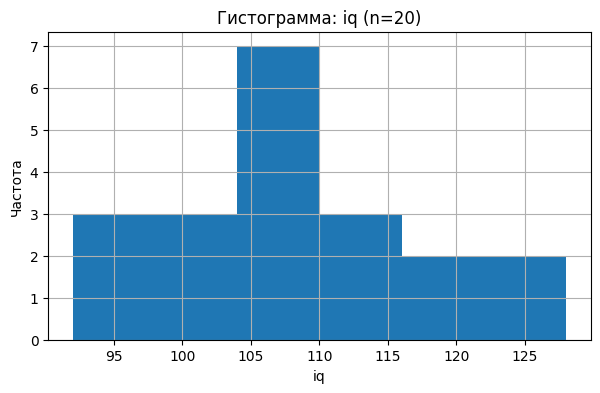

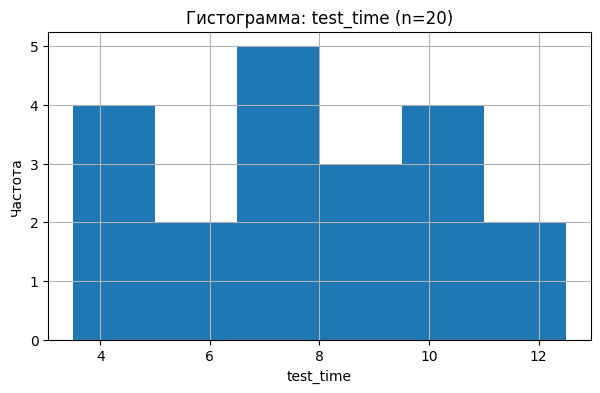

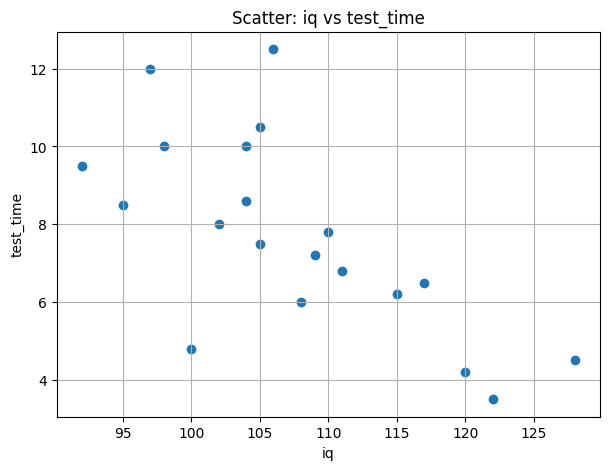

In [45]:
plt.figure(figsize=(7,4))
plt.hist(x, bins='auto')
plt.xlabel(col1)
plt.ylabel('Частота')
plt.title(f'Гистограмма: {col1} (n={len(x)})')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(y, bins='auto')
plt.xlabel(col2)
plt.ylabel('Частота')
plt.title(f'Гистограмма: {col2} (n={len(y)})')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(x, y)
plt.xlabel(col1)
plt.ylabel(col2)
plt.title(f'Scatter: {col1} vs {col2}')
plt.grid(True)
plt.show()

Чем выше IQ, тем меньше времени требуется на прохождение теста. Это проявляется как сильная отрицательная связь (линейная и монотонная), подтверждённая визуально и статистически.

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

Линейная: y = w1*x + w0
   w1 = -0.183111, w0 = 27.396088
   R² = 0.464870

Квадратичная: y = w2*x² + w1*x + w0
   w2 = -0.003300, w1 = 0.539594, w0 = -11.882656
   R² = 0.482521

Гиперболическая: y = w1*(1/x) + w0
   w1 = 2091.874046, w0 = -11.885944
   R² (на 20 точках) = 0.440972

Показательная: y = w0 * w1^x
   w0 = 130.801362, w1 = 0.973507
   R² (на 20 точках) = 0.417448



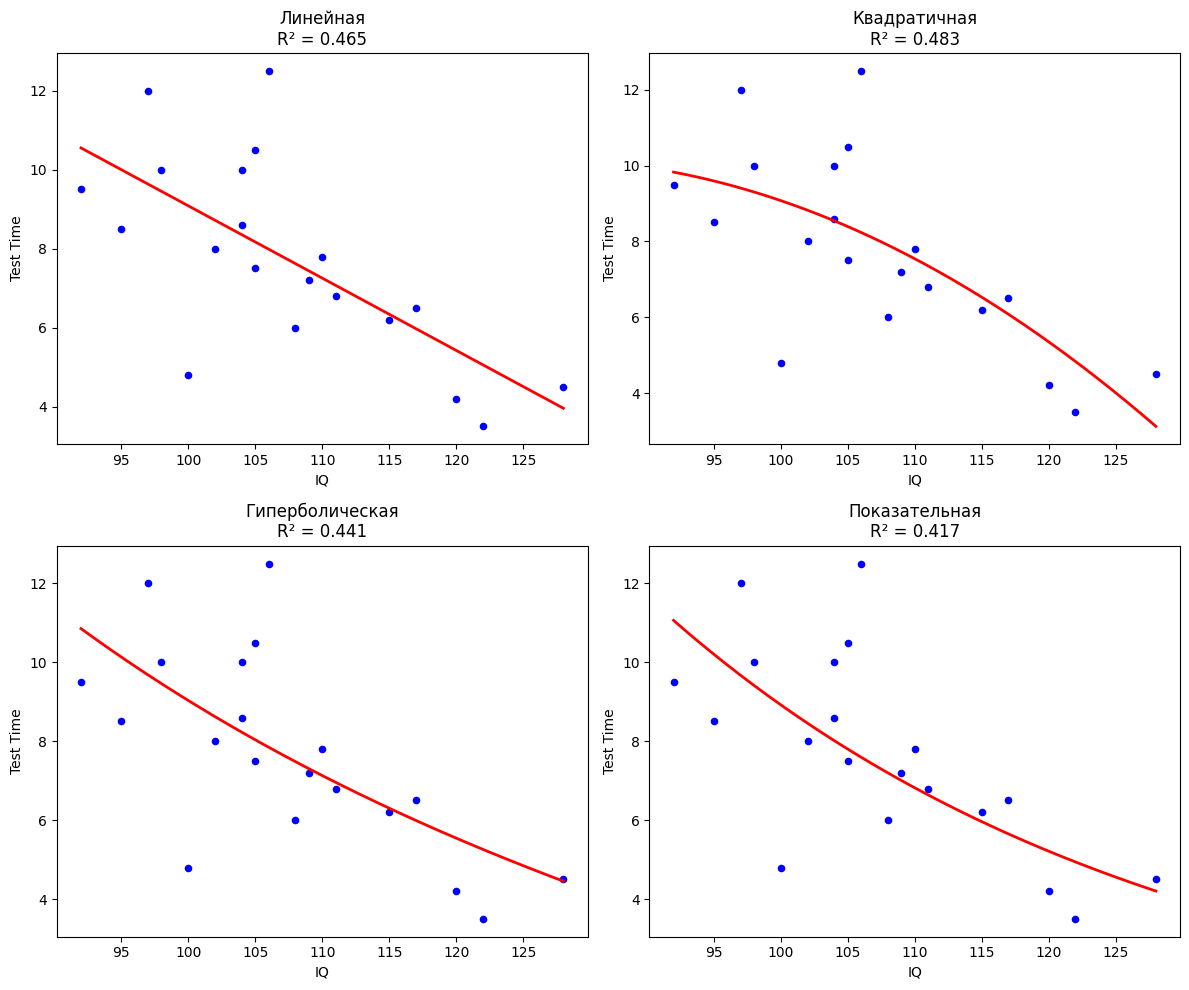

In [54]:
def Rsquare(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else float('nan')

def fit_linear(x, y):
    X = np.column_stack((x, np.ones_like(x)))
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X @ w
    return w, y_pred

def fit_quadratic(x, y):
    X = np.column_stack((x**2, x, np.ones_like(x)))
    w, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X @ w
    return w, y_pred

def fit_hyperbolic(x, y):
    mask = x != 0
    z = 1.0 / x[mask]
    X = np.column_stack((z, np.ones_like(z)))
    w, *_ = np.linalg.lstsq(X, y[mask], rcond=None)
    y_pred = np.full_like(y, np.nan, dtype=float)
    y_pred[mask] = X @ w
    return w, y_pred, mask

def fit_exponential(x, y):
    mask = y > 0
    t = np.log(y[mask])
    X = np.column_stack((x[mask], np.ones_like(x[mask])))
    ab, *_ = np.linalg.lstsq(X, t, rcond=None)
    a, b = ab
    w1 = math.exp(a)
    w0 = math.exp(b)
    y_pred = np.full_like(y, np.nan)
    y_pred[mask] = w0 * (w1 ** x[mask])
    return (w0, w1), y_pred, mask

w_lin, ypred_lin = fit_linear(x, y)
w_quad, ypred_quad = fit_quadratic(x, y)
w_hyp, ypred_hyp, mask_hyp = fit_hyperbolic(x, y)
(w0_exp, w1_exp), ypred_exp, mask_exp = fit_exponential(x, y)

print("Линейная: y = w1*x + w0")
print(f"   w1 = {w_lin[0]:.6f}, w0 = {w_lin[1]:.6f}")
print(f"   R² = {Rsquare(y, ypred_lin):.6f}\n")

print("Квадратичная: y = w2*x² + w1*x + w0")
print(f"   w2 = {w_quad[0]:.6f}, w1 = {w_quad[1]:.6f}, w0 = {w_quad[2]:.6f}")
print(f"   R² = {Rsquare(y, ypred_quad):.6f}\n")

print("Гиперболическая: y = w1*(1/x) + w0")
print(f"   w1 = {w_hyp[0]:.6f}, w0 = {w_hyp[1]:.6f}")
print(f"   R² (на {np.sum(mask_hyp)} точках) = {Rsquare(y[mask_hyp], ypred_hyp[mask_hyp]):.6f}\n")

print("Показательная: y = w0 * w1^x")
print(f"   w0 = {w0_exp:.6f}, w1 = {w1_exp:.6f}")
print(f"   R² (на {np.sum(mask_exp)} точках) = {Rsquare(y[mask_exp], ypred_exp[mask_exp]):.6f}\n")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
xs = np.linspace(np.min(x), np.max(x), 200)

# Линейная
axes[0].scatter(x, y, color="blue", s=20)
axes[0].plot(xs, w_lin[0]*xs + w_lin[1], linewidth=2, color='red')
axes[0].set_title(f"Линейная\nR² = {Rsquare(y, ypred_lin):.3f}")
axes[0].set_xlabel("IQ"); axes[0].set_ylabel("Test Time")

# Квадратичная
axes[1].scatter(x, y, color="blue", s=20)
yquad_line = w_quad[0]*xs**2 + w_quad[1]*xs + w_quad[2]
axes[1].plot(xs, yquad_line, linewidth=2, color='red')
axes[1].set_title(f"Квадратичная\nR² = {Rsquare(y, ypred_quad):.3f}")
axes[1].set_xlabel("IQ"); axes[1].set_ylabel("Test Time")

# Гиперболическая
axes[2].scatter(x, y, color="blue", s=20)
xs_h = xs[xs != 0]
yhy_line = w_hyp[0]*(1.0/xs_h) + w_hyp[1]
axes[2].plot(xs_h, yhy_line, linewidth=2, color='red')
axes[2].set_title(f"Гиперболическая\nR² = {Rsquare(y[mask_hyp], ypred_hyp[mask_hyp]):.3f}")
axes[2].set_xlabel("IQ"); axes[2].set_ylabel("Test Time")

# Показательная
axes[3].scatter(x, y, color="blue", s=20)
yexp_line = w0_exp * (w1_exp ** xs)
axes[3].plot(xs, yexp_line, linewidth=2, color='red')
axes[3].set_title(f"Показательная\nR² = {Rsquare(y[mask_exp], ypred_exp[mask_exp]):.3f}")
axes[3].set_xlabel("IQ"); axes[3].set_ylabel("Test Time")

plt.tight_layout()
plt.show()

Вывод: корреляция есть и довольно сильная

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

In [58]:
def fisher_f_test(y_true, y_pred, k, alpha=0.05):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n = y_true.size
    y_mean = np.mean(y_true)

    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_reg = ss_tot - ss_res

    df_reg = k - 1
    df_res = n - k

    ms_reg = ss_reg / df_reg
    ms_res = ss_res / df_res
    F = ms_reg / ms_res
    p = stats.f.sf(F, df_reg, df_res)
    F_crit = stats.f.ppf(1 - alpha, df_reg, df_res)

    return {
        "F": F, "p_value": p,
        "ss_reg": ss_reg, "ss_res": ss_res, "ss_tot": ss_tot,
        "df_reg": df_reg, "df_res": df_res, "F_crit": F_crit
    }

def result(res, alpha=0.05):
    s = []
    s.append(f"F = {res['F']:.4g}, df_reg = {res['df_reg']}, df_res = {res['df_res']}")
    s.append(f"p-value = {res['p_value']:.4g}, критическое F (alpha={alpha}) = {res['F_crit']:.4g}")

    if res["p_value"] < alpha:
        s.append("Результат статистически значим: отвергаем H₀ — модель объясняет значимую долю вариации y.")
    else:
        s.append("Результат не значим: нет оснований считать, что модель лучше константы.")

    return "\n".join(s)

# print("Линейная модель:")
# print(result(fisher_f_test(y, ypred_lin, k=2)))

print("\nКвадратичная модель:")
print(result(fisher_f_test(y, ypred_quad, k=3)))

# print("\nГиперболическая модель:")
# print(result(fisher_f_test(y[mask_hyp], ypred_hyp[mask_hyp], k=2)))

print("\nПоказательгая модель:")
print(result(fisher_f_test(y[mask_exp], ypred_exp[mask_exp], k=2)))



Квадратичная модель:
F = 7.926, df_reg = 2, df_res = 17
p-value = 0.003699, критическое F (alpha=0.05) = 3.592
Результат статистически значим: отвергаем H₀ — модель объясняет значимую долю вариации y.

Показательгая модель:
F = 12.9, df_reg = 1, df_res = 18
p-value = 0.002086, критическое F (alpha=0.05) = 4.414
Результат статистически значим: отвергаем H₀ — модель объясняет значимую долю вариации y.


Обе модели отвергают H₀: они объясняют существенную долю дисперсии в данных.

Показательная модель имеет более высокую F-статистику и меньший p-value, несмотря на то, что у неё меньше параметров (df_reg = 1).

Это говорит о том, что экспоненциальная зависимость может быть более эффективной, несмотря на более низкий R².

Между IQ и временем прохождения теста существует сильная, статистически значимая отрицательная связь. Люди с более высоким IQ, как правило, быстрее справляются с тестом, и это подтверждается:

Коэффициентами корреляции

Графическим анализом

Регрессионными моделями

F-тестом Фишера

Наиболее сбалансированной моделью является линейная, но квадратичная и гиперболическая тоже дают хорошие результаты. Выбор зависит от того, насколько сложную форму зависимости ты хочешь описать.

In [59]:
!pip freeze

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.0
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.10.6.0.35.25
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.2
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.24.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
cla